# 1. Package Importing



In [1]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
#create spark session
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('nlp').getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Data visualization

In [4]:
text_df= spark.read.csv("/content/drive/MyDrive/cs631_final_project/data/kindle_reviews.csv",inferSchema=True,header=True,sep=',')
#text_df= spark.read.csv("/content/drive/MyDrive/cs631/kindle_reviews.csv",inferSchema=True,header=True,sep=',')
df_raw = text_df.select('overall','reviewText')
#.limit(100000)
df_raw = df_raw.dropna(how='any')
df_raw.printSchema()


root
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)



In [5]:
df_raw.show(5)

+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|      5|I enjoy vintage b...|
|      4|This book is a re...|
|      4|This was a fairly...|
|      5|I'd never read an...|
|      4|If you like perio...|
+-------+--------------------+
only showing top 5 rows



In [6]:
df_pd = df_raw.toPandas()
df_pd['overall'].value_counts()

5    575246
4    254010
3     96193
2     34130
1     23018
Name: overall, dtype: int64

In [7]:
from pyspark.sql import SQLContext
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df_raw.registerTempTable('initial')
sqlContext = SQLContext(spark)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


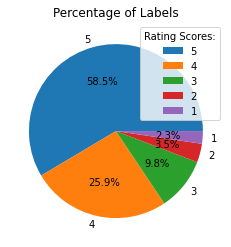

In [9]:
#df_pd = df_raw.toPandas()
fig = plt.pie(df_pd['overall'].value_counts(), autopct = '%1.1f%%', labels = [5,4,3,2,1])
plt.title('Percentage of Labels')
plt.legend(title = "Rating Scores:")
plt.savefig('pie_chart_raw.png')
plt.show()

In [10]:
df_pd = df_pd.replace([1,2,3], 'negative')
df_pd = df_pd.replace(4, 'neutral')
df_pd = df_pd.replace(5, 'positive')

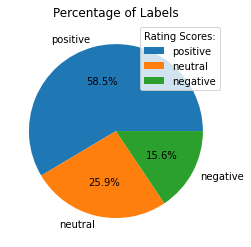

In [11]:
fig = plt.pie(df_pd['overall'].value_counts(), autopct = '%1.1f%%', labels = ['positive','neutral','negative'])
plt.title('Percentage of Labels')
plt.legend(title = "Rating Scores:")
plt.savefig('pie_chart_convert.png')
plt.show()

In [12]:
df_pd = df_pd.replace('neutral', 'negative')

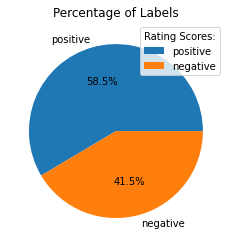

In [13]:
fig = plt.pie(df_pd['overall'].value_counts(), autopct = '%1.1f%%', labels = ['positive','negative'])
plt.title('Percentage of Labels')
plt.legend(title = "Rating Scores:")
plt.savefig('pie_chart_convert.png')
plt.show()

In [14]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [15]:
word_neg = df_raw.filter('overall in (1,2,3)').select('reviewText').toPandas()
word_neutral = df_raw.filter('overall in (4)').select('reviewText').toPandas()
word_pos = df_raw.filter('overall in (5)').select('reviewText').toPandas()
word_neg = " ".join(i for i in word_neg['reviewText'])
word_neutral = " ".join(i for i in word_neutral['reviewText'])
word_pos = " ".join(i for i in word_pos['reviewText'])

In [16]:
stopwords = set(STOPWORDS)

In [17]:
wordcloud_neg = WordCloud(stopwords=stopwords,collocations = True,
                      background_color="white", colormap = "Blues").generate(word_neg)
wordcloud_neutral = WordCloud(stopwords=stopwords,collocations = True,
                      background_color="white", colormap = "afmhot").generate(word_neutral)
wordcloud_pos = WordCloud(stopwords=stopwords,collocations = True,
                      background_color="white", colormap = "Set1").generate(word_pos)

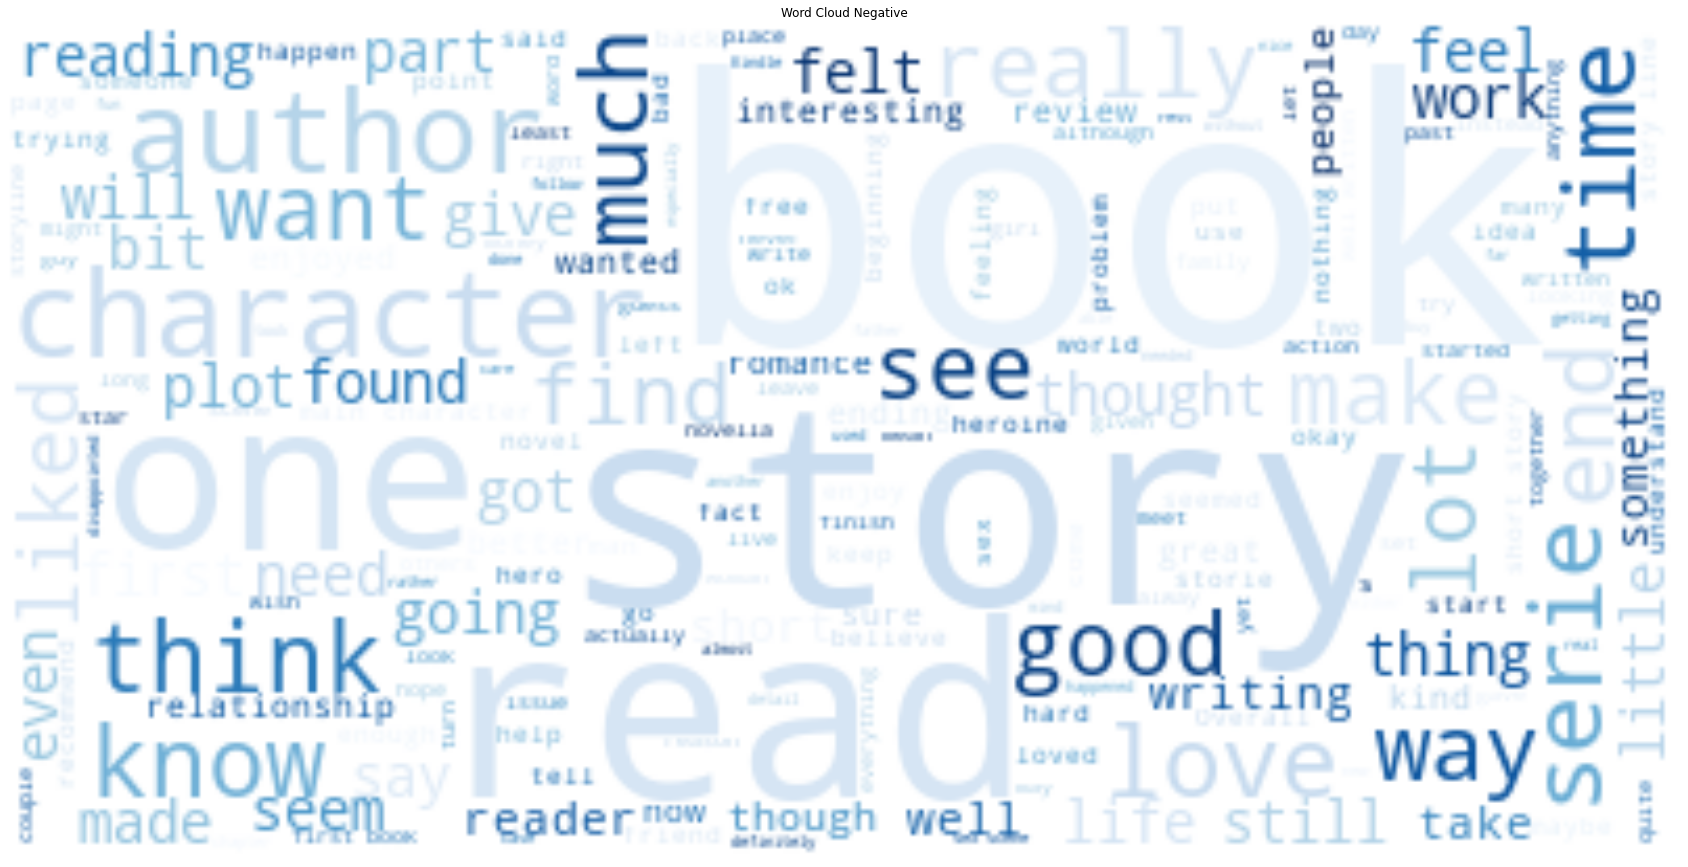

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud Negative')
plt.savefig('word_cloud_negative.png')
plt.show()

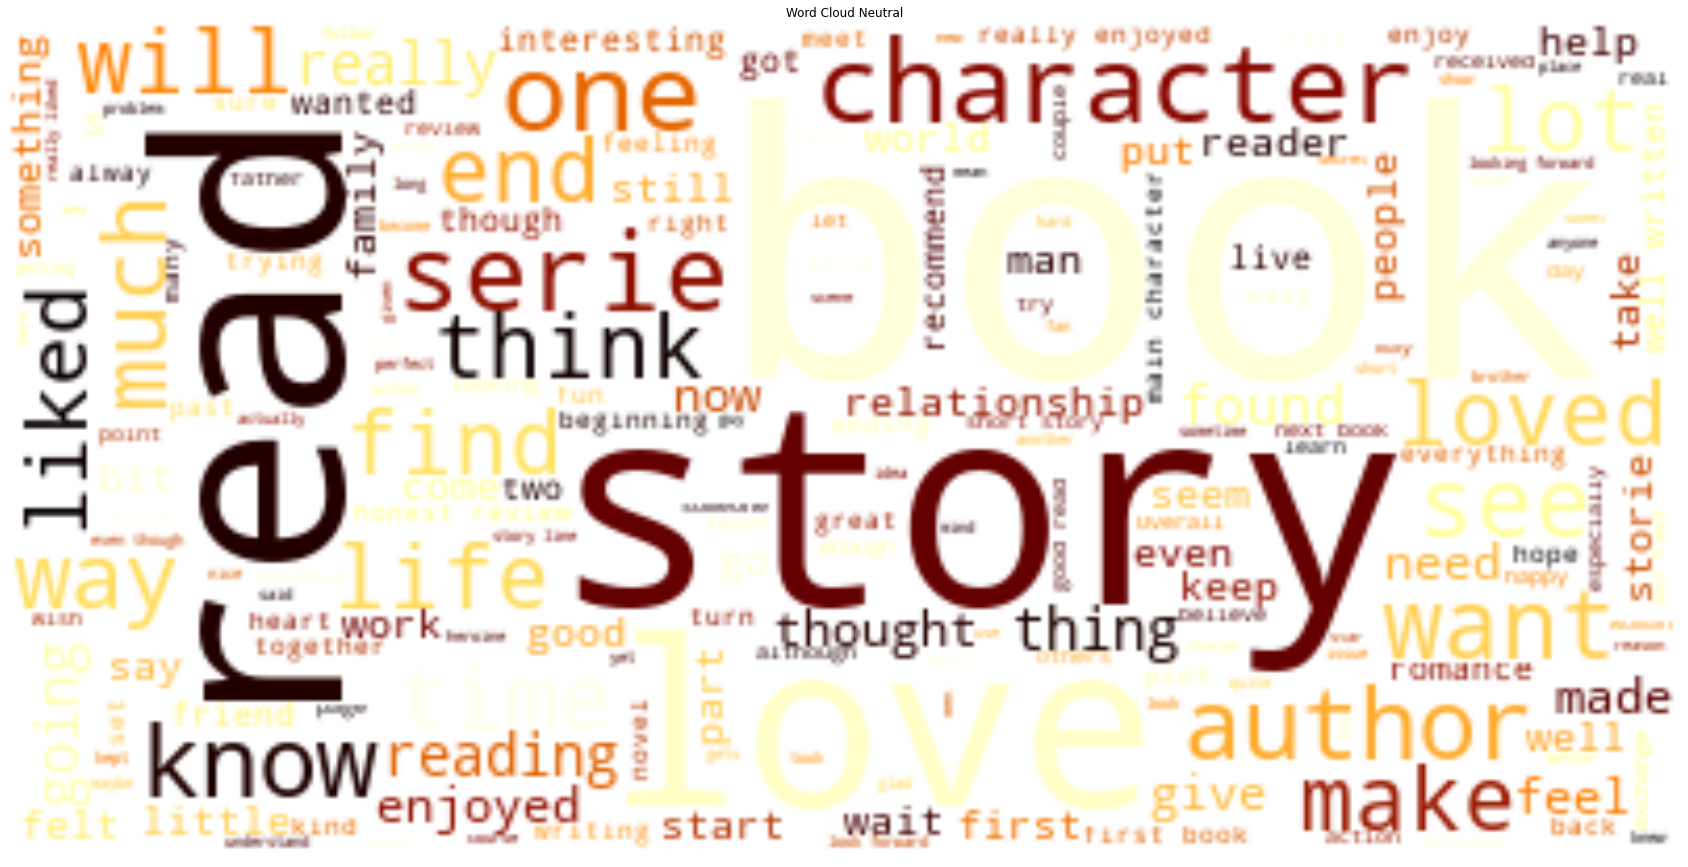

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud Neutral')
plt.savefig('word_cloud_neutral.png')
plt.show()

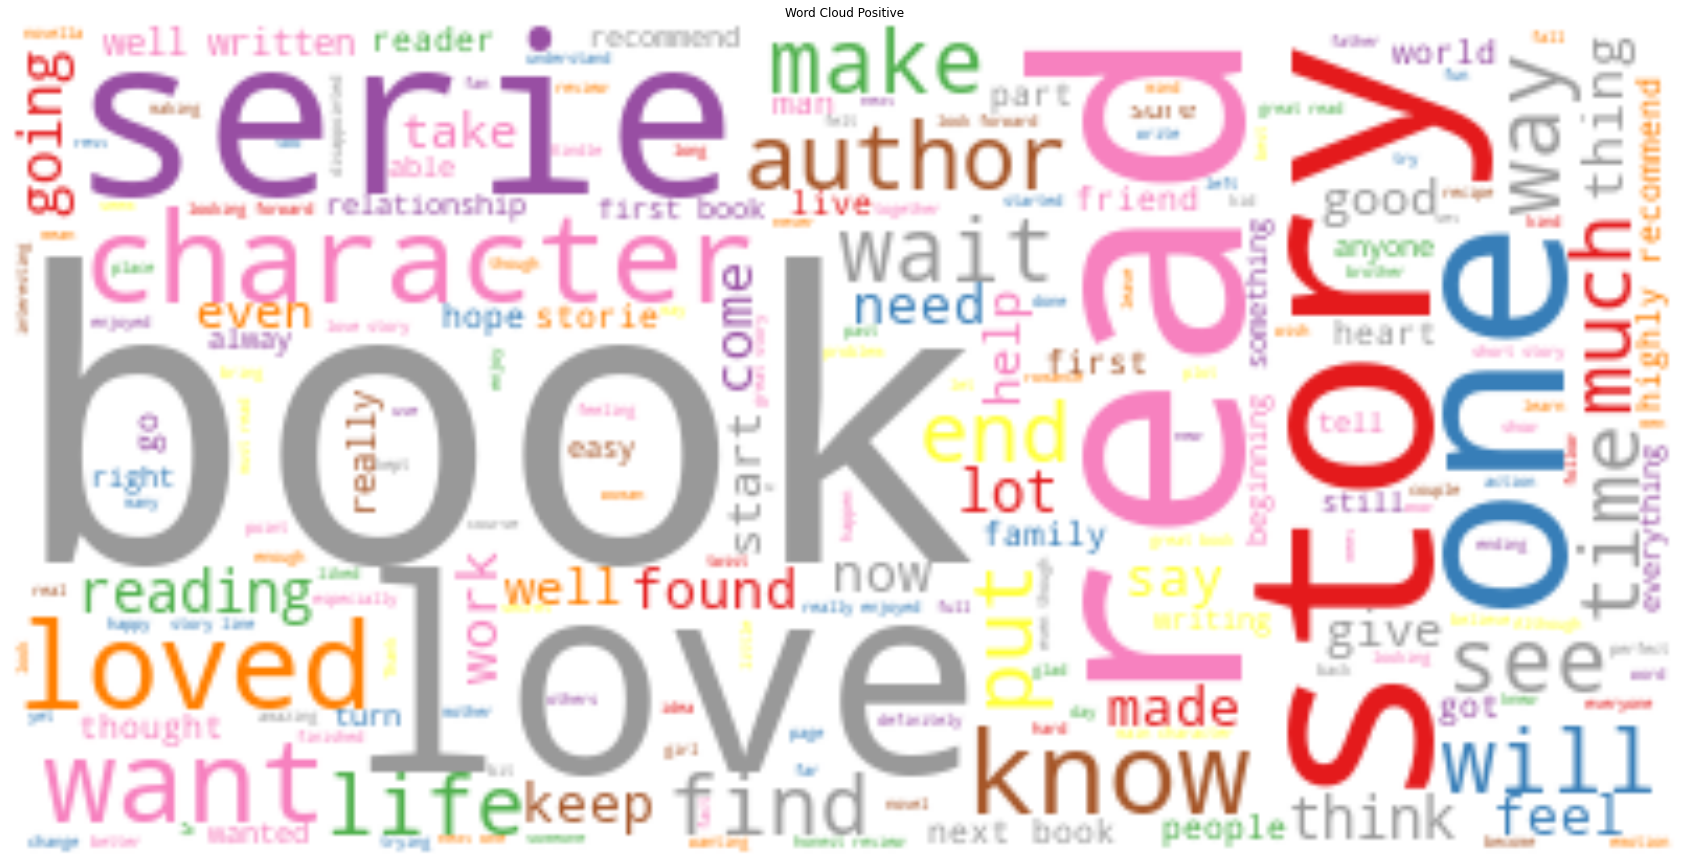

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud Positive')
plt.savefig('word_cloud_positive.png')
plt.show()

In [21]:
df = df_raw.withColumn("Label", text_df.overall.cast('float')).drop('overall')
df = df.dropna(how='any')
df.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  5.0|575246|
|  2.0| 34130|
|  3.0| 96193|
|  1.0| 23018|
|  4.0|254010|
+-----+------+



In [22]:
# Add length to the dataframe
from pyspark.sql.functions import length
df= df.withColumn('length',length(df['reviewText']))
df.show()

+--------------------+-----+------+
|          reviewText|Label|length|
+--------------------+-----+------+
|I enjoy vintage b...|  5.0|   294|
|This book is a re...|  4.0|   455|
|This was a fairly...|  4.0|   375|
|I'd never read an...|  5.0|   101|
|If you like perio...|  4.0|   130|
|A beautiful in-de...|  4.0|   163|
|I enjoyed this on...|  4.0|   163|
|Never heard of Am...|  4.0|   286|
|Darth Maul workin...|  5.0|   127|
|This is a short s...|  4.0|   466|
|I think I have th...|  5.0|    93|
|Title has nothing...|  4.0|   255|
|Well written. Int...|  3.0|   181|
|Troy Denning's no...|  3.0|  2295|
|I am not for sure...|  5.0|   266|
|I really enjoyed ...|  5.0|   108|
|Great read enjoye...|  5.0|   112|
|Another well writ...|  3.0|   274|
|This one promises...|  5.0|   115|
|"I have a version...|  4.0|    82|
+--------------------+-----+------+
only showing top 20 rows



In [23]:
len_df.head()

NameError: ignored

In [ ]:
len_df = df.select('length').filter('length < 500').toPandas()
plt.hist(len_df['length'], bins = 20)
#plt.xlim([0, 500])
plt.title('Word Count Histogram')
plt.savefig('word_count_hist.png')
plt.show()

In [ ]:
break

In [ ]:
#Tokenize
from pyspark.ml.feature import Tokenizer
tokenization = Tokenizer(inputCol='reviewText',outputCol='tokens')
tokenized_df= tokenization.transform(df)
tokenized_df.show()

In [ ]:
# Stopwords Removal
from pyspark.ml.feature import StopWordsRemover
stopword_removal=StopWordsRemover(inputCol='tokens',outputCol='refined_tokens')
df=stopword_removal.transform(tokenized_df)
df.show()

In [ ]:
# Tokenization

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
from pyspark.ml.feature import CountVectorizer

In [ ]:
len_udf = udf(lambda s: len(s), IntegerType())
refined_text_df = df.withColumn("token_count", len_udf(col('refined_tokens')))
refined_text_df.show()

In [ ]:
# import string, re
# # remove punctuation
# rdd = refined_text_df.rdd.map(lambda x: (x[5],x[1],re.sub(r'[^\w\s]', ' ', x[4])))
# # lowercase
# rdd = rdd.map(lambda x: (x[5],x[1],x[4].lower()))
# # remove numbers
# rdd = rdd.map(lambda x: (x[5],x[1],re.sub(r'\d+', '', x[4])))
# # remove double spaces
# rdd = rdd.map(lambda x: (x[5],x[1]," ".join(x[4].split())))
# # only keep letters
# rdd = rdd.map(lambda x: (x[5],x[1],re.sub('[^a-zA-Z]+', ' ', x[4])))

# new_df = rdd.toDF(["token_count","Label","refined_tokens"])
# #new_df.withColumn("_c0", new_df._c0.cast('bigint'))
# new_df

In [ ]:
#refined_text_df.orderBy("token_count").show(10)

In [ ]:
count_vec=CountVectorizer(inputCol='refined_tokens',outputCol='features').setVocabSize(10000)

In [ ]:
%%time
cv_text_df= count_vec.fit(refined_text_df).transform(refined_text_df)


In [ ]:
cv_text_df = cv_text_df.select(['refined_tokens','token_count','features','Label'])
cv_text_df.show(10)

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
df_assembler = VectorAssembler(inputCols=['features','token_count'],outputCol='features_vec')
model_text_df = df_assembler.transform(cv_text_df)

In [ ]:
model_text_df.show()

# 3.Model

In [ ]:
#split the data 
training_df,test_df=model_text_df.randomSplit([0.75,0.25])

## 3.1 Logistic Regression


In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
training_df.printSchema()
#training_df.groupBy('label').count().show()

In [ ]:
%%time
log_model =LogisticRegression(featuresCol='features_vec',labelCol='Label').fit(training_df)

In [ ]:
results = log_reg.evaluate(test_df).predictions

In [ ]:
results.show()

## 3.2
